In [81]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import ADASYN, SMOTE
from scipy.stats import kurtosis
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from xgboost import XGBClassifier

Model is trained and tested on the fourth_batch with train test split.

In [82]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [83]:
def engineer_features(df_X, df_y=None):
    # Basic user features
    df_user_features = df_X.groupby("user").agg(
        mean_rating=("rating", "mean"),
        median_rating=("rating", "median"),
        std_rating=("rating", "std"),
        count_dislike=("rating", lambda x: (x == -10).sum()),
        count_neutral=("rating", lambda x: (x == 0).sum()),
        count_like=("rating", lambda x: (x == 10).sum()),
        count_watched=("rating", lambda x: (x == 1).sum()),
        total_interactions=("rating", "count"),
    )

    # Ratio features
    df_user_features["like_ratio"] = (
        df_user_features["count_like"] / df_user_features["total_interactions"]
    )
    df_user_features["dislike_ratio"] = (
        df_user_features["count_dislike"] / df_user_features["total_interactions"]
    )
    df_user_features["neutral_ratio"] = (
        df_user_features["count_neutral"] / df_user_features["total_interactions"]
    )
    df_user_features["watched_ratio"] = (
        df_user_features["count_watched"] / df_user_features["total_interactions"]
    )

    # Weighted scores
    df_user_features["weighted_score"] = (
        df_user_features["count_like"] * 1.5 - df_user_features["count_dislike"] * 1.5
    )

    # Distribution features
    df_user_features["rating_kurtosis"] = df_X.groupby("user")["rating"].apply(
        lambda x: kurtosis(x)
    )

    # Item popularity metrics
    item_popularity = df_X.groupby("item")["rating"].agg(["mean", "count"])
    item_popularity["popularity_score"] = item_popularity["mean"] * np.log1p(
        item_popularity["count"]
    )

    # Fill NaN values in std_rating and rating_kurtosis
    df_user_features["std_rating"] = df_user_features["std_rating"].fillna(0)
    df_user_features["rating_kurtosis"] = df_user_features["rating_kurtosis"].fillna(0)

    # Merge item popularity with user interactions
    df_X_with_popularity = pd.merge(
        df_X, item_popularity["popularity_score"], left_on="item", right_index=True
    )

    # New features
    df_user_features["avg_deviation_from_popularity"] = df_X_with_popularity.groupby(
        "user"
    ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())

    # Drop columns with high correlation
    # Count watch has high correlation with total interactions
    df_user_features.drop(columns=["total_interactions"], inplace=True)

    # Drop columns with low mutual information
    df_user_features.drop(columns=["median_rating"], inplace=True)
    df_user_features.drop(columns=["mean_rating"], inplace=True)

    if df_y is not None:
        df_merged = pd.merge(df_user_features.reset_index(), df_y, on="user")
        # Return the merged dataframe with selected features, label, and top features
        return df_merged
    else:
        return df_user_features

In [85]:
# Load fourth batch data
first_data = np.load("data/first_batch_multi_labels.npz")
X1, y1 = pd.DataFrame(first_data['X']), pd.DataFrame(first_data['yy'])

second_data = np.load("data/second_batch_multi_labels.npz")
X2, y2 = pd.DataFrame(second_data['X']), pd.DataFrame(second_data['yy'])

third_data = np.load("data/third_batch_multi_labels.npz")
X3, y3 = pd.DataFrame(third_data['X']), pd.DataFrame(third_data['yy'])

fourth_data = np.load("data/fourth_batch_multi_labels.npz")
X4, y4 = pd.DataFrame(fourth_data['X']), pd.DataFrame(fourth_data['yy'])

# Concat all into fourth
fourth_data = {
    "X": pd.concat([X1, X2, X3, X4], axis = 0).to_numpy(),
    'yy': pd.concat([y1, y2, y3, y4], axis = 0).to_numpy()
}

# Load fourth batch data
fourth_interaction_data = pd.DataFrame(
    fourth_data["X"], columns=["user", "item", "rating"]
)
fourth_user_labels = pd.DataFrame(fourth_data["yy"], columns=["user", "label"])
fourth_users = fourth_user_labels["user"].unique()

fourth_users

array([   0,    1,    2, ..., 3787, 3788, 3789], dtype=int64)

In [86]:
fourth_features = engineer_features(fourth_interaction_data)

fourth_features

C:\Users\teoju\AppData\Local\Temp\ipykernel_28416\1038901450.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())


,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
0,6.167758,20,24,32,57,0.240602,0.150376,0.180451,0.428571,18.0,-0.307358,17.833604
1,5.238997,8,26,19,39,0.206522,0.086957,0.282609,0.423913,16.5,0.535412,13.745883
2,7.380911,32,6,52,58,0.351351,0.216216,0.040541,0.391892,30.0,-1.037700,12.495912
3,6.107906,36,48,43,85,0.202830,0.169811,0.226415,0.400943,10.5,-0.280708,17.111900
4,4.686725,11,54,42,103,0.200000,0.052381,0.257143,0.490476,46.5,0.999560,16.359302
...,...,...,...,...,...,...,...,...,...,...,...,...
3785,4.502136,0,3,4,6,0.307692,0.000000,0.230769,0.461538,6.0,-1.309731,8.032858
3786,6.429423,138,102,54,149,0.121896,0.311512,0.230248,0.336343,-126.0,-0.781821,13.817212
3787,4.962127,3,33,124,72,0.534483,0.012931,0.142241,0.310345,181.5,-0.956307,11.915026


In [87]:
fourth_X = fourth_features
fourth_y = fourth_user_labels["label"]

# Step 1: Split data into 80% for nested cross-validation and 20% for final evaluation
# X_train, X_holdout, y_train, y_holdout = train_test_split(
#     fourth_X, fourth_y, test_size=0.2, random_state=RANDOM_SEED, stratify=fourth_y
# )

X_train = fourth_X
y_train = fourth_y

# print(X_train.shape, X_holdout.shape)

In [88]:
# print("Train set label distribution")
# print(y_train.value_counts())
# print("Holdout set label distribution")
# print(y_holdout.value_counts())

In [89]:
# Upsample the minority class using SMOTE
smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train = X_train_resampled
y_train = y_train_resampled

In [90]:
print(y_train.value_counts())

label
0    3500
1    3500
2    3500
Name: count, dtype: int64


In [91]:
# Scale fourth_fifth_features using StandardScaler and replace the original features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# X_holdout_scaled = scaler.transform(X_holdout)

X_train_scaled = pd.DataFrame(
    X_train_scaled, index=X_train.index, columns=X_train.columns
)
# X_holdout_scaled = pd.DataFrame(
#     X_holdout_scaled, index=X_holdout.index, columns=X_holdout.columns
# )

In [92]:
# Step 2: Define the inner and outer cross-validation strategy
outer_cv = KFold(
    n_splits=5, shuffle=True, random_state=42
)  # Outer loop for model evaluation
inner_cv = KFold(
    n_splits=3, shuffle=True, random_state=42
)  # Inner loop for hyperparameter tuning

In [93]:
def plot_multiclass_roc_curve(y_true, y_pred_probabilities, class_labels=[0, 1, 2]):
    # Convert labels to binary format
    binarized_labels = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = binarized_labels.shape[1]

    # Initialize dictionaries to store metrics
    false_positive_rates = {}
    true_positive_rates = {}
    auc_scores = {}

    # Create color map for plotting
    colors = ["blue", "green", "red"]

    # Create plot
    plt.figure()

    # Calculate ROC curve and AUC for each class
    for class_idx in range(n_classes):
        # Calculate ROC curve metrics
        false_positive_rates[class_idx], true_positive_rates[class_idx], _ = roc_curve(
            binarized_labels[:, class_idx], y_pred_probabilities[:, class_idx]
        )
        # Calculate AUC score
        auc_scores[class_idx] = auc(
            false_positive_rates[class_idx], true_positive_rates[class_idx]
        )

        # Plot ROC curve for current class
        class_label = (
            f"{class_labels[class_idx]}" if class_labels else f"Class {class_idx}"
        )
        plt.plot(
            false_positive_rates[class_idx],
            true_positive_rates[class_idx],
            color=colors[class_idx],
            lw=2,
            label=f"{class_label} (AUC = {auc_scores[class_idx]:.3f})",
        )

    # Calculate and plot average AUC
    average_auc = sum(auc_scores.values()) / n_classes

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curves")
    plt.text(0.6, 0.3, f"Average AUC Score: {average_auc:.4f}")
    plt.legend(loc="lower right")

    # Show plot
    plt.grid(True, alpha=0.3)
    plt.show()

In [94]:
def calculate_multiclass_roc_auc(y_true, y_pred_proba):
    n_classes = y_pred_proba.shape[1]
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

    # Calculate AUC for each class
    auc_scores = {}
    for i in range(n_classes):
        if (
            len(np.unique(y_true_bin[:, i])) > 1
        ):  # Check if the class exists in this fold
            auc_scores[f"class_{i}"] = roc_auc_score(
                y_true_bin[:, i], y_pred_proba[:, i]
            )

    # Calculate macro average
    macro_auc = np.mean(list(auc_scores.values()))

    return macro_auc, auc_scores

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Fold Results:
Macro Average AUC: 0.992
Class-specific AUC scores:
class_0: 0.985
class_1: 0.994
class_2: 0.998


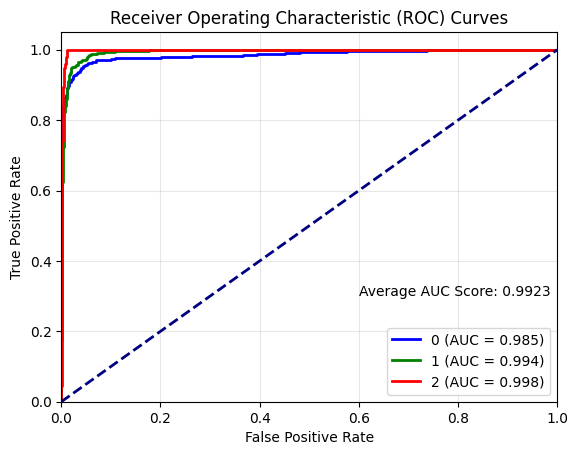

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Fold Results:
Macro Average AUC: 0.993
Class-specific AUC scores:
class_0: 0.987
class_1: 0.994
class_2: 0.999


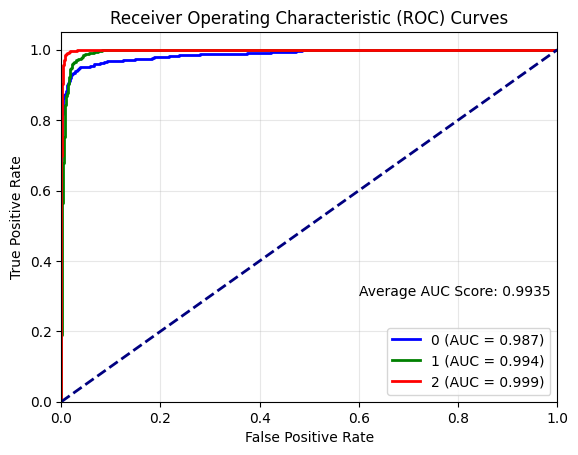

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Fold Results:
Macro Average AUC: 0.994
Class-specific AUC scores:
class_0: 0.988
class_1: 0.996
class_2: 0.999


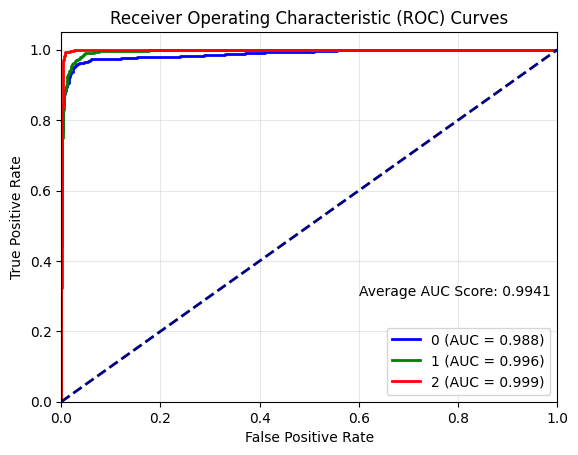

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Fold Results:
Macro Average AUC: 0.996
Class-specific AUC scores:
class_0: 0.990
class_1: 0.997
class_2: 0.999


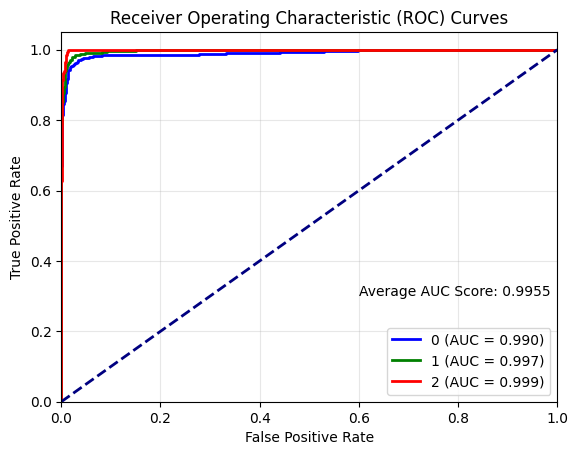

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Fold Results:
Macro Average AUC: 0.994
Class-specific AUC scores:
class_0: 0.988
class_1: 0.996
class_2: 0.998


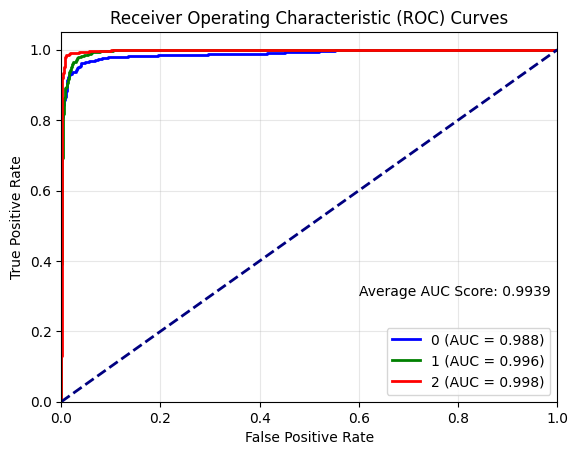


Final Nested CV Results:
Average Macro AUC: 0.994 ± 0.001


In [95]:
# Define Logistic Regression model
logreg_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1500)

# Define Random Forest model
rf_model = RandomForestClassifier(random_state=RANDOM_SEED)

param_shared = {
    "voting__logreg__C": [0.01],
    "voting__logreg__class_weight": [
        {0: 2.5, 1: 4.5, 2: 1},
    ],
    "voting__rf__max_depth": [50],
    "voting__rf__max_features": [0.5],
    "voting__rf__min_samples_leaf": [1],
    "voting__rf__min_samples_split": [5],
    "voting__rf__n_estimators": [175],
    "voting__rf__bootstrap": [False],
    "voting__rf__min_impurity_decrease": [1e-4],

    "voting__weights": [[1, 1]],
}

# Parameter grid for L1 regularization
param_dist_voting_l1 = {
    "voting__logreg__penalty": ["l1"],
    "voting__logreg__solver": ["liblinear"],
    **param_shared
}

# Define the Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ("logreg", logreg_model),
        ("rf", rf_model),
    ],
    voting="soft",  # Use 'soft' voting to combine predicted probabilities
)

# Create a pipeline with the Voting Classifier
pipeline = Pipeline([("voting", voting_clf)])

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=[param_dist_voting_l1],
    n_iter=100,
    scoring="roc_auc_ovr",
    cv=inner_cv,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

# Perform nested cross-validation
outer_scores = []
class_specific_scores = []

for train_index, test_index in outer_cv.split(X_train_scaled):
    # Split data for current fold
    X_train_fold, X_test_fold = (
        X_train_scaled.iloc[train_index],
        X_train_scaled.iloc[test_index],
    )
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit GridSearchCV
    random_search.fit(X_train_fold, y_train_fold)

    # Get predictions
    y_pred_proba = random_search.best_estimator_.predict_proba(X_test_fold)

    # Calculate AUC scores
    macro_auc, class_aucs = calculate_multiclass_roc_auc(y_test_fold, y_pred_proba)
    outer_scores.append(macro_auc)
    class_specific_scores.append(class_aucs)

    # Display results for current fold
    print(f"\nFold Results:")
    print(f"Macro Average AUC: {macro_auc:.3f}")
    print("Class-specific AUC scores:")
    for class_name, auc_score in class_aucs.items():
        print(f"{class_name}: {auc_score:.3f}")

    # Plot ROC curve for current fold
    plot_multiclass_roc_curve(
        y_test_fold,
        y_pred_proba,
    )

# Display final nested CV results
print("\nFinal Nested CV Results:")
print("Average Macro AUC: %.3f ± %.3f" % (np.mean(outer_scores), np.std(outer_scores)))

In [98]:
# print(f"Best Hyperparameters: {random_search.best_params_}")
from sklearn.base import clone

# Step 7: Evaluate the final model on the holdout set
# Refit the model with best parameters from the whole training data
best_model_final = clone(random_search.best_estimator_)
best_model_final.fit(X_train_scaled, y_train)

# Test on holdout set and display ROC curve
# y_holdout_pred_probabilities = best_model_final.predict_proba(X_holdout_scaled)
# plot_multiclass_roc_curve(y_holdout, y_holdout_pred_probabilities)

Pipeline(steps=[('voting',
                 VotingClassifier(estimators=[('logreg',
                                               LogisticRegression(C=0.01,
                                                                  class_weight={0: 2.5,
                                                                                1: 4.5,
                                                                                2: 1},
                                                                  max_iter=1500,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='liblinear')),
                                              ('rf',
                                               RandomForestClassifier(bootstrap=False,
                                                                      max_depth=50,
                                                                      max_features=0.5,
                                                                      min_impurity_decrease=0.0001,
                                                                      min_samples_split=5,
                                                                      n_estimators=175,
                                                                      random_state=42))],
                                  voting='soft', weights=[1, 1]))])

In [99]:
fifth_data_with_labels = np.load("data/fifth_batch_multi_labels.npz")
fifth_user_labels = pd.DataFrame(
    fifth_data_with_labels["yy"], columns=["user", "label"]
)

fifth_interaction_data = pd.DataFrame(
    fifth_data_with_labels["X"], columns=["user", "item", "rating"]
)

fifth_features = engineer_features(fifth_interaction_data)

fifth_features

C:\Users\teoju\AppData\Local\Temp\ipykernel_28416\1038901450.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())


,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
3790,5.480485,1,3,17,7,0.607143,0.035714,0.107143,0.250000,24.0,0.299984,11.201149
3791,8.989782,6,1,7,3,0.411765,0.352941,0.058824,0.176471,1.5,-1.663088,23.123969
3792,7.011842,19,21,45,32,0.384615,0.162393,0.179487,0.273504,39.0,-0.816920,12.435839
3793,4.976308,0,3,5,3,0.454545,0.000000,0.272727,0.272727,7.5,-1.948977,16.731619
3794,4.826087,12,91,47,73,0.210762,0.053812,0.408072,0.327354,52.5,0.705454,15.927917
...,...,...,...,...,...,...,...,...,...,...,...,...
5435,6.040867,4,12,15,13,0.340909,0.090909,0.272727,0.295455,16.5,-0.346299,18.201929
5436,5.705941,5,17,42,30,0.446809,0.053191,0.180851,0.319149,55.5,-0.322267,15.485094
5437,5.259704,8,39,123,98,0.458955,0.029851,0.145522,0.365672,172.5,-0.517903,13.421144


In [102]:
fifth_features_scaled = scaler.transform(fifth_features)

fifth_features_scaled = pd.DataFrame(
    fifth_features_scaled, index=fifth_features.index, columns=fifth_features.columns
)

fifth_features_scaled

,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
3790,0.030068,-0.736627,-0.770123,-0.543544,-1.053731,3.535247,-0.932263,-0.349175,-2.610386,0.080840,0.322292,-1.685009
3791,4.123827,-0.532919,-0.860695,-0.885890,-1.114454,1.666654,2.773809,-1.062942,-3.331409,-0.469779,-1.797058,2.490793
3792,1.816468,-0.003279,0.045018,0.415024,-0.674216,1.406998,0.547691,0.719487,-2.379906,0.447918,-0.883528,-1.252575
3793,-0.558079,-0.777368,-0.770123,-0.954360,-1.114454,2.075808,-1.349502,2.096818,-2.387525,-0.322947,-2.105707,0.251962
3794,-0.733318,-0.288470,3.215014,0.483494,-0.051811,-0.255729,-0.720836,4.096109,-1.851858,0.778289,0.760041,-0.029524
...,...,...,...,...,...,...,...,...,...,...,...,...
5435,0.683779,-0.614402,-0.362553,-0.612014,-0.962648,0.988992,-0.287437,2.096818,-2.164663,-0.102700,-0.375442,0.766917
5436,0.293073,-0.573661,-0.136124,0.312321,-0.704577,2.001812,-0.728081,0.739634,-1.932319,0.851705,-0.349496,-0.184616
5437,-0.227484,-0.451436,0.860160,3.085324,0.327705,2.117983,-1.000765,0.217763,-1.476121,3.714919,-0.560707,-0.907486


In [103]:
y_pred_proba_fifth = best_model_final.predict_proba(fifth_features_scaled)

df_predictions_fifth = pd.DataFrame(
    {
        "user": fifth_user_labels.index,
        "z0": y_pred_proba_fifth[:, 0],
        "z1": y_pred_proba_fifth[:, 1],
        "z2": y_pred_proba_fifth[:, 2],
        "predicted_class": np.argmax(y_pred_proba_fifth, axis=1),
    }
).set_index("user")

df_predictions_fifth = df_predictions_fifth.join(fifth_user_labels)

df_predictions_fifth

,z0,z1,z2,predicted_class,user,label
user,,,,,,
0,0.698443,0.301510,0.000047,0,3790,0
1,0.630477,0.025408,0.344115,0,3791,0
2,0.578084,0.395750,0.026166,0,3792,0
3,0.747694,0.251065,0.001242,0,3793,0
4,0.777941,0.221949,0.000110,0,3794,0
...,...,...,...,...,...,...
1645,0.755385,0.238284,0.006331,0,5435,0
1646,0.800374,0.198081,0.001545,0,5436,0
1647,0.948575,0.050423,0.001002,0,5437,0


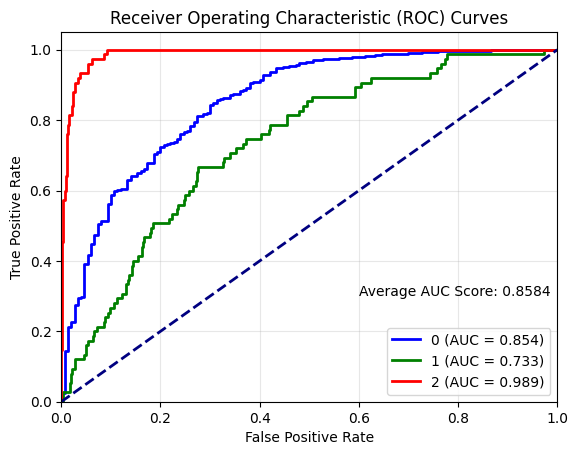

Average ROC AUC: 0.8584


In [104]:
roc_auc = calculate_multiclass_roc_auc(df_predictions_fifth["label"], y_pred_proba_fifth)
plot_multiclass_roc_curve(df_predictions_fifth["label"], y_pred_proba_fifth)

# Average ROC AUC to 4 decimal places
print(f"Average ROC AUC: {roc_auc[0]:.4f}")

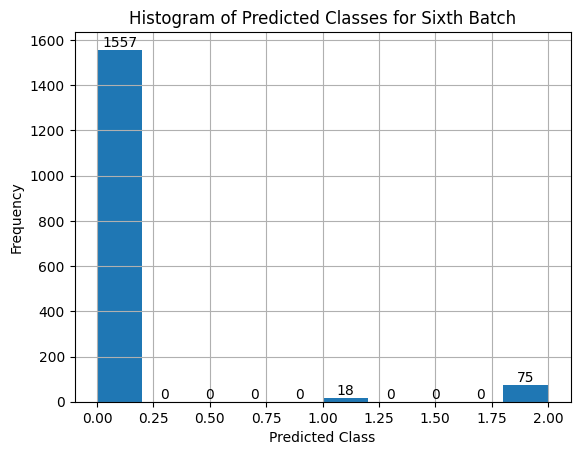

In [106]:
# Plot histogram of predicted classes
ax = df_predictions_fifth["predicted_class"].hist()
plt.title("Histogram of Predicted Classes for Sixth Batch")
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")

# Add frequency labels on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')
plt.show()

In [107]:
sixth_data = np.load("data/sixth_batch_multi.npz")

sixth_interaction_data = pd.DataFrame(
    sixth_data["X"], columns=["user", "item", "rating"]
)

sixth_features = engineer_features(sixth_interaction_data)

sixth_features_scaled = scaler.transform(sixth_features)

sixth_features_scaled = pd.DataFrame(
    sixth_features_scaled, index=sixth_features.index, columns=sixth_features.columns
)

sixth_features_scaled

C:\Users\teoju\AppData\Local\Temp\ipykernel_28416\1038901450.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())


,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
5440,0.771375,0.322654,1.358302,2.434866,0.373246,1.255686,-0.230944,0.687251,-1.549819,2.320020,-0.384957,-0.623001
5441,-0.514834,-0.288470,1.539445,-0.166964,-0.309881,-0.486179,-0.414885,3.385999,-1.400991,0.080840,0.871450,0.621783
5442,-0.948136,-0.247728,2.037587,-0.509310,-0.431326,-1.075958,-0.294813,4.735984,-1.793228,-0.322947,1.753094,1.154984
5443,2.302006,0.281912,-0.317267,0.106913,-0.613493,0.830376,1.386990,-0.201836,-1.881569,-0.139408,-1.203065,0.769987
5444,0.587734,0.567103,2.354586,4.591646,1.086735,1.531365,-0.431575,0.600446,-1.606449,4.412369,-0.335133,-1.192017
...,...,...,...,...,...,...,...,...,...,...,...,...
7635,-0.023856,-0.736627,-0.724838,-0.509310,-1.038551,3.281823,-0.972641,-0.025827,-2.531307,0.117547,-0.011679,-0.401591
7636,0.957646,4.274585,3.260299,0.449259,1.117097,-1.203632,2.166655,1.366698,-1.491752,-3.369701,-0.765513,-0.266095
7637,-1.177935,-0.736627,0.090304,-0.509310,-0.719758,0.187854,-1.182606,2.710714,-0.999416,0.117547,-0.141562,-0.594686


In [108]:
y_pred_proba_sixth = best_model_final.predict_proba(sixth_features_scaled)

df_predictions_sixth = pd.DataFrame(
    {
        "user": sixth_features_scaled.index,
        "z0": y_pred_proba_sixth[:, 0],
        "z1": y_pred_proba_sixth[:, 1],
        "z2": y_pred_proba_sixth[:, 2],
        "predicted_class": np.argmax(y_pred_proba_sixth, axis=1),
    }
).set_index("user")

df_predictions_sixth

,z0,z1,z2,predicted_class
user,,,,
5440,0.925628,0.057220,0.017152,0
5441,0.766359,0.232638,0.001003,0
5442,0.763027,0.236724,0.000250,0
5443,0.433295,0.162538,0.404167,0
5444,0.981379,0.010897,0.007725,0
...,...,...,...,...
7635,0.568872,0.431003,0.000125,0
7636,0.867763,0.056834,0.075403,0
7637,0.735473,0.264393,0.000134,0


In [109]:
df_final = df_predictions_sixth.drop(['predicted_class'], axis = 1)
np.savez("cs421-g1-team3-week12-scores-v1.0.npz",scores=df_predictions_sixth.to_numpy())

In [110]:
assert np.isclose(np.sum(np.load("cs421-g1-team3-week12-scores-v1.0.npz")['scores'][0]), 1.0)

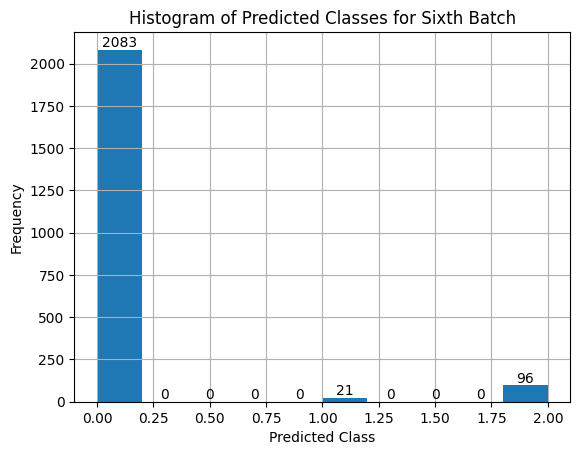

In [111]:
# Plot histogram of predicted classes
ax = df_predictions_sixth["predicted_class"].hist()
plt.title("Histogram of Predicted Classes for Sixth Batch")
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")

# Add frequency labels on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')
plt.show()